In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm

# 修改为你的文件夹路径
FOLDER = r"D:/code_VScode_Python/11711/final-project-711-JCAP/results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_easy_10"

game_logs = []
player_logs = {i: [] for i in range(5)}  # 5-player game

# ---- Load game logs ----
for fname in sorted(os.listdir(FOLDER)):
    if fname.startswith("game_log") and fname.endswith(".json"):
        with open(os.path.join(FOLDER, fname), "r", encoding="utf-8") as f:
            game_logs.append(json.load(f))

# ---- Load player logs ----
for i in range(5):
    path = os.path.join(FOLDER, f"player_log_{i}.jsonl")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                player_logs[i].append(json.loads(line))

len(game_logs), {k: len(v) for k,v in player_logs.items()}

(10, {0: 10, 1: 10, 2: 10, 3: 10, 4: 10})

In [2]:
import numpy as np

# 胜率（根据 player_log 是否存在 win 字段）
player_win_rate = {}

for pid, logs in player_logs.items():
    df = pd.DataFrame(logs)
    if "win" in df.columns:
        player_win_rate[pid] = df["win"].mean()
    else:
        # 兼容：若 win 字段不存在，则从 game log 中判断
        wins = 0
        for row in game_logs:
            if row["metadata"]["winner"] == "civilians" and pid != row["metadata"]["spy_id"]:
                wins += 1
            elif row["metadata"]["winner"] == "spy" and pid == row["metadata"]["spy_id"]:
                wins += 1
        player_win_rate[pid] = wins / len(game_logs)

player_win_rate

{0: 0.9, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7}

In [3]:
spy_wins = 0
for g in game_logs:
    if g["metadata"]["winner"] == "spy":
        spy_wins += 1

spy_win_rate = spy_wins / len(game_logs)
spy_win_rate


0.1

In [5]:
spy_survival_rounds = []

for g in game_logs:
    spy_id = g["metadata"]["spy_id"]

    # 找到 vote_reveal 或死亡事件的 round
    last_alive_round = 1
    for item in g["public_log"]:
        if item["phase"] == "vote_reveal":
            last_alive_round = item["round_num"]
    
    spy_survival_rounds.append(last_alive_round)

avg_spy_survival = np.mean(spy_survival_rounds)
avg_spy_survival

np.float64(1.7)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

spy_survival_rounds = []

for g in game_logs:
    # 每局的卧底 ID
    spy_id = g["metadata"]["spy_id"]

    # 记录当前卧底最后存活到第几轮
    # 逻辑：只要还在 vote_reveal 的轮次里出现 -> 说明这一轮卧底还活着
    last_round_alive = 1

    for item in g["public_log"]:
        if item.get("phase") == "vote_reveal":
            round_num = item["round_num"]
            last_round_alive = round_num

            # 检查该轮有没有被淘汰
            # “vote_result” 会告诉你是否被 eliminated
        if item.get("phase") == "vote_result":
            # 如果卧底被淘汰，这条消息结构如下：
            # "Player X receives Y votes and is eliminated."
            content = item["content"]
            if f"Player {spy_id} receives" in content:
                # 卧底死在这一轮
                break

    spy_survival_rounds.append(last_round_alive)

spy_survival_rounds

[1, 1, 1, 1, 1, 2, 2, 1, 4, 3]

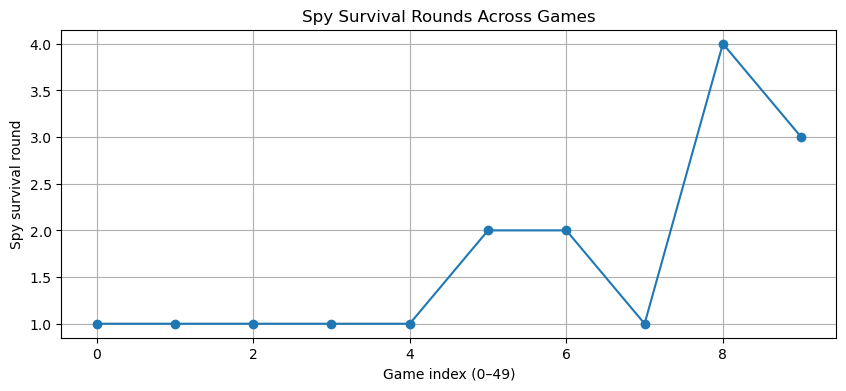

In [7]:
plt.figure(figsize=(10,4))
plt.plot(spy_survival_rounds, marker="o")
plt.xlabel("Game index (0–49)")
plt.ylabel("Spy survival round")
plt.title("Spy Survival Rounds Across Games")
plt.grid(True)
plt.show()


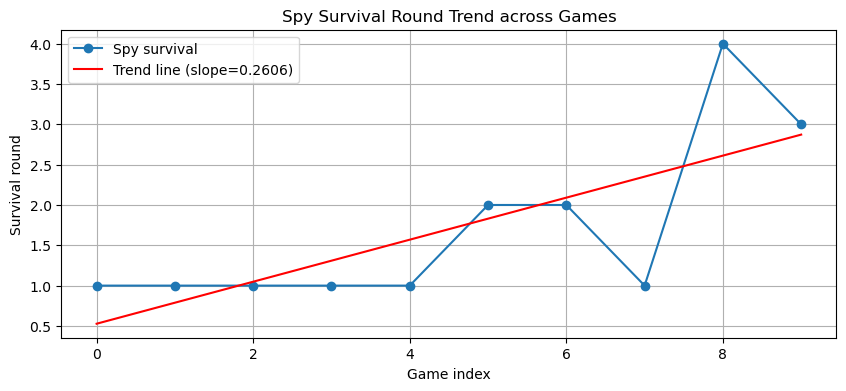

In [8]:
x = np.arange(len(spy_survival_rounds))
y = np.array(spy_survival_rounds)

coef = np.polyfit(x, y, 1)
trend_line = coef[0] * x + coef[1]

plt.figure(figsize=(10,4))
plt.plot(x, y, marker="o", label="Spy survival")
plt.plot(x, trend_line, color="red", label=f"Trend line (slope={coef[0]:.4f})")
plt.xlabel("Game index")
plt.ylabel("Survival round")
plt.title("Spy Survival Round Trend across Games")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
alive_round1 = 0
alive_round2 = 0

for g in game_logs:
    spy_id = g["metadata"]["spy_id"]

    all_rounds = [item["round_num"] for item in g["public_log"] if item["phase"] == "vote_reveal"]
    last_round = max(all_rounds) if len(all_rounds) else 1

    if last_round >= 1:
        alive_round1 += 1
    if last_round >= 2:
        alive_round2 += 1

alive_round1_ratio = alive_round1 / len(game_logs)
alive_round2_ratio = alive_round2 / len(game_logs)

alive_round1_ratio, alive_round2_ratio

(1.0, 0.4)

In [10]:
def compute_spy_survival_stats_round_based(game_logs):
    """
    基于“游戏持续轮数”的卧底生存统计：
    - alive_round1_ratio:  第1轮结束后卧底仍然存活的比例 ≈ 持续到第2轮的对局比例
    - alive_round2_ratio:  第2轮结束后卧底仍然存活的比例 ≈ 持续到第3轮的对局比例
    - last_rounds:         每局游戏的最后一轮轮数（用于画生存曲线）
    """
    total_games = len(game_logs)
    alive_round1 = 0  # 持续到第2轮的对局数
    alive_round2 = 0  # 持续到第3轮的对局数
    last_rounds = []

    for g in game_logs:
        # 找出这局所有 vote_reveal 的轮次
        all_rounds = [
            item["round_num"]
            for item in g["public_log"]
            if item["phase"] == "vote_reveal"
        ]

        # 如果极端情况没有 vote_reveal，默认算 1 轮
        last_round = max(all_rounds) if all_rounds else 1
        last_rounds.append(last_round)

        # 第1轮结束后仍然活着：游戏至少有第2轮
        if last_round >= 2:
            alive_round1 += 1

        # 第2轮结束后仍然活着：游戏至少有第3轮
        if last_round >= 3:
            alive_round2 += 1

    alive_round1_ratio = alive_round1 / total_games
    alive_round2_ratio = alive_round2 / total_games

    return {
        "alive_round1_ratio": alive_round1_ratio,
        "alive_round2_ratio": alive_round2_ratio,
        "last_rounds": last_rounds,
    }


In [11]:
stats = compute_spy_survival_stats_round_based(game_logs)
stats["alive_round1_ratio"], stats["alive_round2_ratio"]



(0.4, 0.2)

In [107]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spy_survival_curves_across_models(model_last_rounds_dict, max_k=6):
    """
    画多模型对比的 Spy Survival Curve (SR@k)

    参数：
    model_last_rounds_dict: dict
        {
            "DeepSeek Civ vs Gemini Spy": [2,1,3,2,1,...],
            "DeepSeek Civ vs GPT Spy":    [3,2,2,1,...],
            ...
        }

    max_k: 最大画到第几轮 k（例如你的图是 6）
    """

    plt.figure()

    for model_name, last_rounds in model_last_rounds_dict.items():
        last_rounds = np.array(last_rounds)
        total_games = len(last_rounds)

        survival_probs = []

        for k in range(1, max_k + 1):
            # SR@k = P(last_round >= k+1)
            alive = np.sum(last_rounds >= (k + 1))
            survival_probs.append(alive / total_games)

        plt.plot(range(1, max_k + 1), survival_probs, marker="o", label=model_name)

    plt.xlabel("Round k")
    plt.ylabel("Survival Probability")
    plt.title("Spy Survival Curve (SR@k) Across Models")
    plt.grid(True)
    plt.legend()
    plt.show()


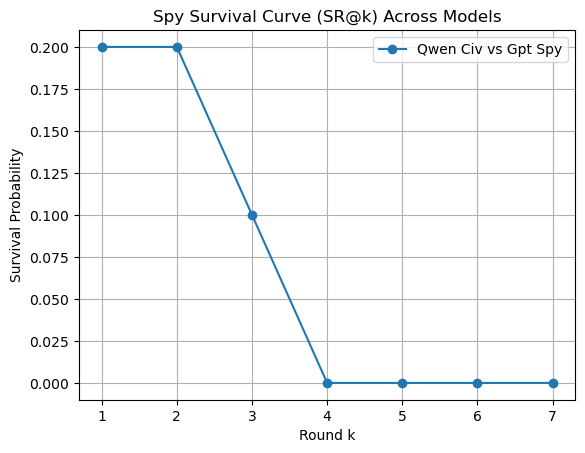

In [108]:
stats_gpt = compute_spy_survival_stats_round_based(game_logs)
model_last_rounds_dict = {
    "Qwen Civ vs Gpt Spy": stats_gpt["last_rounds"]
}
plot_spy_survival_curves_across_models(model_last_rounds_dict, max_k=7)


In [109]:
import re
import numpy as np
import matplotlib.pyplot as plt

spy_votes_per_game = []

for g in game_logs:
    spy_id = g["metadata"]["spy_id"]
    total_votes_for_spy = 0

    # 遍历这一局里所有轮次的 vote_reveal
    for item in g["public_log"]:
        if item.get("phase") != "vote_reveal":
            continue
        
        content = item["content"]
        # 去掉换行，保留 "Player x votes for Player y" 这几段
        tail = content.split("result is:")[-1]
        segments = tail.replace("\n", " ").strip().split(",")

        for seg in segments:
            seg = seg.strip()
            m = re.search(r"Player\s+(\d+)\s+votes\s+for\s+Player\s+(\d+)", seg)
            if not m:
                continue
            voter = int(m.group(1))
            target = int(m.group(2))

            if target == spy_id:
                total_votes_for_spy += 1

    spy_votes_per_game.append(total_votes_for_spy)

spy_votes_per_game

[4, 3, 3, 3, 4, 3, 3, 4, 3, 3]

In [110]:
avg_spy_votes = float(np.mean(spy_votes_per_game))
max_spy_votes = int(np.max(spy_votes_per_game))

avg_spy_votes, max_spy_votes


(3.3, 4)

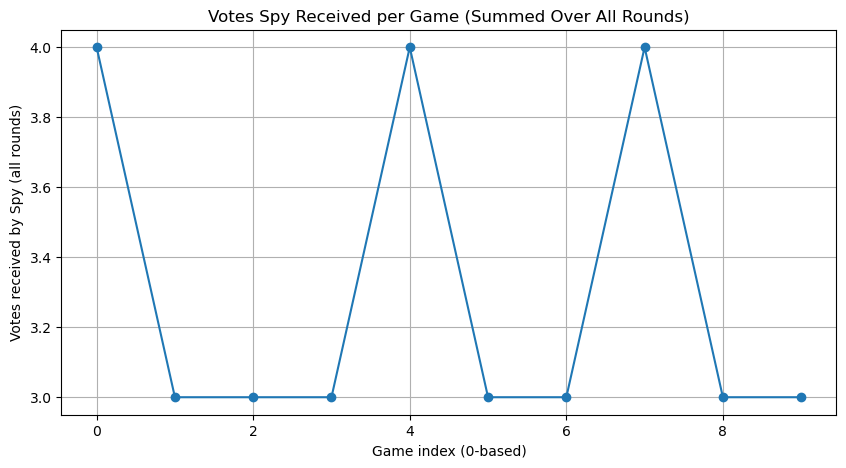

In [111]:
plt.figure(figsize=(10,5))
plt.plot(range(len(spy_votes_per_game)), spy_votes_per_game, marker="o")
plt.xlabel("Game index (0-based)")
plt.ylabel("Votes received by Spy (all rounds)")
plt.title("Votes Spy Received per Game (Summed Over All Rounds)")
plt.grid(True)
plt.show()

In [113]:
import re
import numpy as np
import matplotlib.pyplot as plt

# 结果结构
# 每一局的数据是一维数组，例如 [2, 1, 3]
spy_votes_per_round_all_games = []
avg_votes_per_round_each_game = []

for g in game_logs:
    spy_id = g["metadata"]["spy_id"]

    # 这一局：按 round_id 记录卧底被投的票
    round_votes = {}

    for item in g["public_log"]:
        if item.get("phase") != "vote_reveal":
            continue
        
        round_id = item["round_num"]
        content = item["content"]
        
        tail = content.split("result is:")[-1]
        segments = (
            tail.replace("\n", " ")
                .strip()
                .split(",")
        )
        
        votes_for_spy_this_round = 0

        for seg in segments:
            seg = seg.strip()
            m = re.search(r"Player\s+(\d+)\s+votes\s+for\s+Player\s+(\d+)", seg)
            if not m:
                continue

            target = int(m.group(2))
            if target == spy_id:
                votes_for_spy_this_round += 1
        
        round_votes[round_id] = votes_for_spy_this_round
        # 转成按 round 排序的数组
    votes_array = [round_votes[r] for r in sorted(round_votes.keys())]
    spy_votes_per_round_all_games.append(votes_array)

    # 这一局的平均值
    avg_votes = np.mean(votes_array) if len(votes_array) > 0 else 0
    avg_votes_per_round_each_game.append(avg_votes)

spy_votes_per_round_all_games, avg_votes_per_round_each_game

([[4], [3], [1, 1, 1], [3], [4], [3], [3], [4], [3], [0, 0, 1, 2]],
 [np.float64(4.0),
  np.float64(3.0),
  np.float64(1.0),
  np.float64(3.0),
  np.float64(4.0),
  np.float64(3.0),
  np.float64(3.0),
  np.float64(4.0),
  np.float64(3.0),
  np.float64(0.75)])

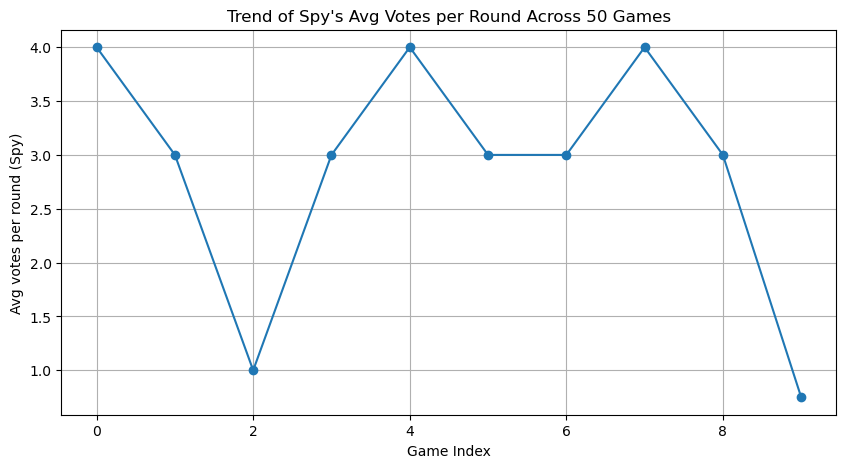

In [114]:
plt.figure(figsize=(10,5))
plt.plot(avg_votes_per_round_each_game, marker="o")
plt.xlabel("Game Index")
plt.ylabel("Avg votes per round (Spy)")
plt.title("Trend of Spy's Avg Votes per Round Across 50 Games")
plt.grid(True)
plt.show()


In [12]:
import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_game_folder(folder):
    """加载一个实验文件夹中的所有 game_log_x.json & player_log_x.jsonl"""
    game_logs = []
    player_logs = {i: [] for i in range(5)}

    # 加载 game_log
    for fname in sorted(os.listdir(folder)):
        if fname.startswith("game_log") and fname.endswith(".json"):
            with open(os.path.join(folder, fname), "r", encoding="utf-8") as f:
                game_logs.append(json.load(f))

    # 加载 player_log
    for pid in range(5):
        fpath = os.path.join(folder, f"player_log_{pid}.jsonl")
        if os.path.exists(fpath):
            with open(fpath, "r", encoding="utf-8") as f:
                for line in f:
                    player_logs[pid].append(json.loads(line))

    return game_logs, player_logs


def compute_survival_rounds(game_logs):
    """统计每一局卧底活了几轮（根据 vote_reveal + vote_result）"""
    spy_survival = []

    for g in game_logs:
        spy = g["metadata"]["spy_id"]
        last_round = 1
        for item in g["public_log"]:
            if item.get("phase") == "vote_reveal":
                last_round = item["round_num"]

            if item.get("phase") == "vote_result":
                if f"Player {spy} receives" in item["content"]:
                    break

        spy_survival.append(last_round)

    return spy_survival


def compute_spy_win_rate(game_logs):
    """卧底胜率"""
    wins = sum(1 for g in game_logs if g["metadata"]["winner"] == "spy")
    return wins / len(game_logs)


def compute_votes_per_round(game_logs):
    """每一局：卧底每一轮被投多少票 → 平均值"""
    avg_votes = []

    for g in game_logs:
        spy = g["metadata"]["spy_id"]
        votes_round = {}

        for item in g["public_log"]:
            if item.get("phase") != "vote_reveal":
                continue

            r = item["round_num"]
            text = item["content"]

            tail = text.split("result is:")[-1].replace("\n", " ").strip()
            parts = tail.split(",")
            cnt = 0

            for seg in parts:
                m = re.search(r"Player\s+(\d+)\s+votes\s+for\s+Player\s+(\d+)", seg)
                if m:
                    tgt = int(m.group(2))
                    if tgt == spy:
                        cnt += 1
            votes_round[r] = cnt

        avg_votes.append(np.mean(list(votes_round.values())))

    return avg_votes

In [28]:
FOLDER_NO_CHEAT = r"D:/code_VScode_Python/11711/final-project-711-JCAP/results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_easy_10"
FOLDER_CHEAT = r"D:/code_VScode_Python/11711/final-project-711-JCAP/results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_easy_10"

game_no_cheat, player_no_cheat = load_game_folder(FOLDER_NO_CHEAT)
game_cheat, player_cheat = load_game_folder(FOLDER_CHEAT)


In [29]:
# 卧底胜率
win_no_cheat = compute_spy_win_rate(game_no_cheat)
win_cheat = compute_spy_win_rate(game_cheat)

# 生存轮数
survive_no = compute_survival_rounds(game_no_cheat)
survive_ch = compute_survival_rounds(game_cheat)

# 平均每轮被投票数
votes_no = compute_votes_per_round(game_no_cheat)
votes_ch = compute_votes_per_round(game_cheat)

win_no_cheat,win_cheat,np.mean(survive_no),np.mean(survive_ch), np.mean(votes_no),np.mean(votes_ch)


(0.1,
 0.1,
 np.float64(1.7),
 np.float64(1.7),
 np.float64(2.25),
 np.float64(2.25))

In [35]:
def compute_alive_ratio(game_logs,k):
    """
    返回：
    alive_round1_ratio: 卧底活到第1轮的比例
    alive_round2_ratio: 卧底活到第2轮的比例
    """

    alive_k = 0

    for g in game_logs:
        # 一局的最大轮数
        max_round = 0
        for item in g["public_log"]:
            max_round = max(max_round, item["round_num"])

        if max_round > k:
            alive_k += 1

    total = len(game_logs)
    return alive_k / total if total > 0 else 0


In [36]:
alive1_no = compute_alive_ratio(game_no_cheat,1)
alive2_no = compute_alive_ratio(game_no_cheat,2)
alive1_ch= compute_alive_ratio(game_cheat,1)
alive2_ch = compute_alive_ratio(game_cheat,2)

alive1_no, alive2_no, alive1_ch, alive2_ch


(0.4, 0.2, 0.4, 0.2)

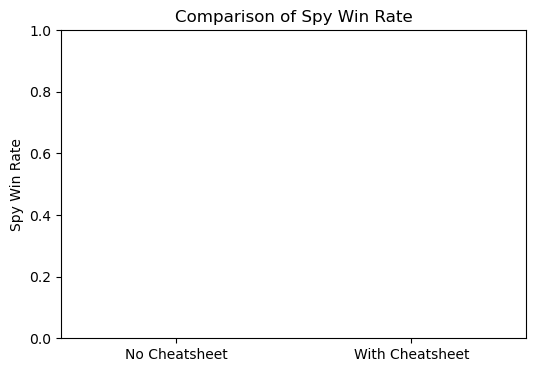

In [123]:
plt.figure(figsize=(6,4))
plt.bar(["No Cheatsheet", "With Cheatsheet"], [win_no_cheat, win_cheat], color=["gray","green"])
plt.ylabel("Spy Win Rate")
plt.title("Comparison of Spy Win Rate")
plt.ylim(0,1)
plt.show()


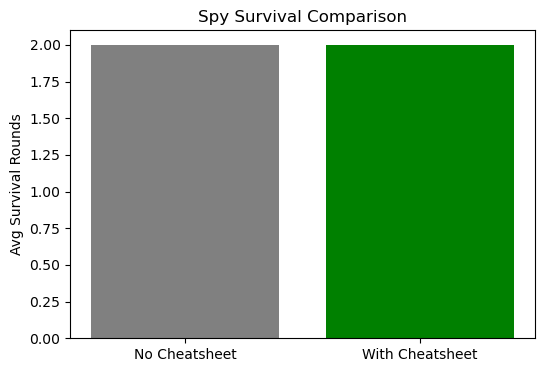

In [85]:
plt.figure(figsize=(6,4))
plt.bar(["No Cheatsheet", "With Cheatsheet"], 
        [np.mean(survive_no), np.mean(survive_ch)], 
        color=["gray","green"])
plt.ylabel("Avg Survival Rounds")
plt.title("Spy Survival Comparison")
plt.show()

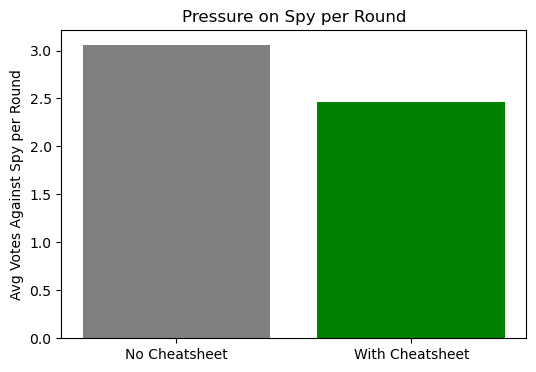

In [20]:
plt.figure(figsize=(6,4))
plt.bar(["No Cheatsheet", "With Cheatsheet"], 
        [np.mean(votes_no), np.mean(votes_ch)],
        color=["gray","green"])
plt.ylabel("Avg Votes Against Spy per Round")
plt.title("Pressure on Spy per Round")
plt.show()

In [86]:
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_game_folder(folder):
    game_logs = []
    for fname in sorted(os.listdir(folder)):
        if fname.startswith("game_log") and fname.endswith(".json"):
            with open(os.path.join(folder, fname), "r", encoding="utf-8") as f:
                game_logs.append(json.load(f))
    return game_logs


def compute_votes_each_round(game_logs):
    """
    返回：list of lists，每局一个 list，例如：
    [
        [2,1,3],         # game 0
        [0,2],           # game 1
        [1,1,2,2],       # game 2
        ...
    ]
    """
    result = []

    for g in game_logs:
        spy = g["metadata"]["spy_id"]
        round_votes = {}

        for item in g["public_log"]:
            if item.get("phase") != "vote_reveal":
                continue

            r = item["round_num"]
            text = item["content"]
            tail = text.split("result is:")[-1].replace("\n", " ").strip()
            parts = tail.split(",")

            cnt = 0
            for seg in parts:
                m = re.search(r"Player\s+(\d+)\s+votes\s+for\s+Player\s+(\d+)", seg)
                if m:
                    if int(m.group(2)) == spy:
                        cnt += 1

            round_votes[r] = cnt

        # 按轮次排序成数组
        arr = [round_votes[r] for r in sorted(round_votes.keys())]
        result.append(arr)

    return result


In [87]:
data = []

for i in range(len(votes_no)):
    entry = {
        "Game": i,
        "NoCheat_votes_each_round": votes_no[i],
        "Cheat_votes_each_round": votes_ch[i],
        "NoCheat_avg": np.mean(votes_no[i]),
        "Cheat_avg": np.mean(votes_ch[i]),
    }
    data.append(entry)

df_compare = pd.DataFrame(data)
df_compare


,Game,NoCheat_votes_each_round,Cheat_votes_each_round,NoCheat_avg,Cheat_avg
0,0,4.000000,4.000000,4.000000,4.000000
1,1,1.500000,1.500000,1.500000,1.500000
2,2,4.000000,4.000000,4.000000,4.000000
3,3,4.000000,4.000000,4.000000,4.000000
4,4,4.000000,4.000000,4.000000,4.000000
5,5,2.000000,2.000000,2.000000,2.000000
6,6,1.250000,1.250000,1.250000,1.250000
7,7,1.000000,1.000000,1.000000,1.000000
8,8,3.000000,3.000000,3.000000,3.000000
9,9,1.333333,1.333333,1.333333,1.333333


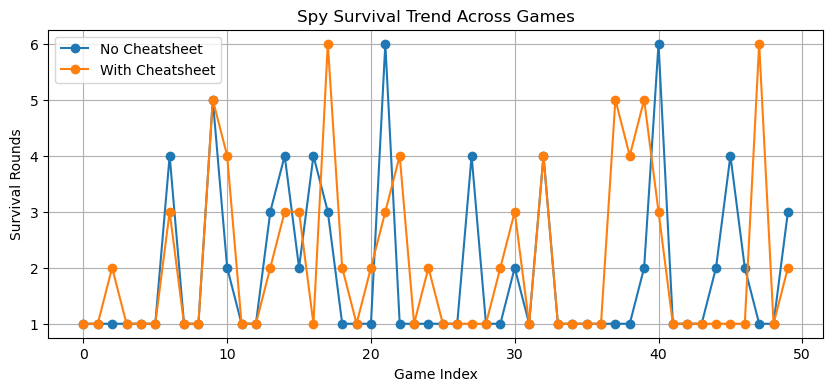

In [21]:
plt.figure(figsize=(10,4))
plt.plot(survive_no, label="No Cheatsheet", marker="o")
plt.plot(survive_ch, label="With Cheatsheet", marker="o")
plt.xlabel("Game Index")
plt.ylabel("Survival Rounds")
plt.title("Spy Survival Trend Across Games")
plt.legend()
plt.grid(True)
plt.show()

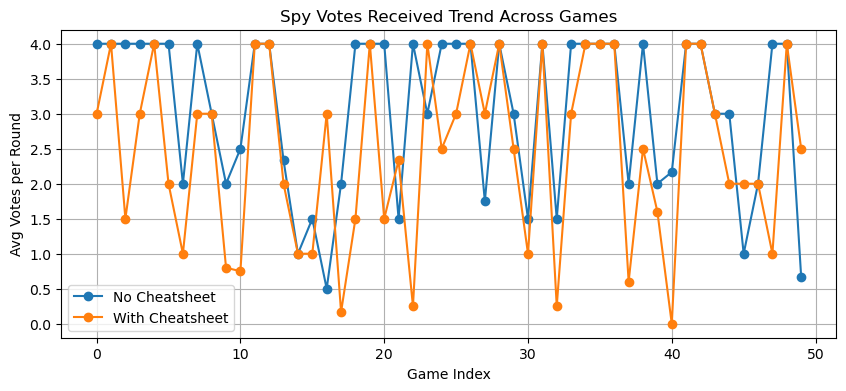

In [22]:
plt.figure(figsize=(10,4))
plt.plot(votes_no, label="No Cheatsheet", marker="o")
plt.plot(votes_ch, label="With Cheatsheet", marker="o")
plt.xlabel("Game Index")
plt.ylabel("Avg Votes per Round")
plt.title("Spy Votes Received Trend Across Games")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import os
import json
import glob
from collections import defaultdict


In [23]:
def load_all_game_logs(game_log_dir):
    game_logs = []
    for p in sorted(glob.glob(os.path.join(game_log_dir, "game_log_*.json"))):
        with open(p, "r", encoding="utf-8") as f:
            game_logs.append(json.load(f))
    return game_logs


def load_all_player_logs(player_log_dir):
    """
    返回格式：
    {
        player_id: [ {record}, {record}, ... ]
    }
    """
    player_logs = defaultdict(list)

    for p in glob.glob(os.path.join(player_log_dir, "player_log_*.jsonl")):
        player_id = int(os.path.basename(p).split("_")[2].split(".")[0])
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                player_logs[player_id].append(json.loads(line))

    return player_logs


In [26]:
import re

def compute_civilian_elimination_VSR_ratio_by_round(game_logs):
    total_rounds = 0
    civilian_elimination_rounds = 0

    for g in game_logs:
        players = g["metadata"]["players"]
        role_map = {p["player_id"]: p["role"] for p in players}

        public_log = g["public_log"]

        for item in public_log:
            # ✅ 每一个 vote_reveal 都代表一轮投票
            if item["phase"] == "vote_reveal":
                total_rounds += 1

            # ✅ 根据 vote_result 判断这一轮“是否对平民不利”
            if item["phase"] == "vote_result":
                text = item["content"]

                # 情况 1：真的发生了淘汰
                m = re.search(r"Player (\d+) receives \d+ votes and is eliminated", text)
                if m:
                    eliminated_id = int(m.group(1))

                    # ✅ 只要不是“卧底被淘汰”，就算作对平民不利
                    if role_map.get(eliminated_id) != "spy":
                        civilian_elimination_rounds += 1

                else:
                    # ✅ 情况 2：平局 / 无人淘汰 → 也计入对平民不利
                    if "No elimination" in text or "tie" in text.lower():
                        civilian_elimination_rounds += 1

    ratio = civilian_elimination_rounds / total_rounds if total_rounds > 0 else 0.0

    return {
        "civilian_elimination_ratio": ratio,
        "total_rounds": total_rounds,
        "civilian_elimination_rounds": civilian_elimination_rounds
    }


In [32]:
game_log_dir = "./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_easy_10"
player_log_dir = "./results/civ_gpt_5mini_spy_qwen_cheatsheet_JCAP_easy_10"

games = load_all_game_logs(game_log_dir)
players = load_all_player_logs(player_log_dir)

vsr_res  = compute_civilian_elimination_VSR_ratio_by_round(games)

vsr_res


{'civilian_elimination_ratio': 0.47058823529411764,
 'total_rounds': 17,
 'civilian_elimination_rounds': 8}